# BM25 Baseline

In [11]:
import json
from math import log
#adding words to stopwords
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import STOPWORDS
#adding custom words to the pre-defined stop words list
all_stopwords_gensim = STOPWORDS

def preprocess(doc):
    # Tokenize the document by whitespace
    tokens = word_tokenize(doc)
    tokens_without_sw = [word for word in tokens if not word in all_stopwords_gensim]
    tokens = tokens_without_sw

    # Calculate document length and term frequencies
    doc_len = len(tokens)
    tf = {}
    for token in tokens:
        if token not in tf:
            tf[token] = 0
        tf[token] += 1

    return {"len": doc_len, "tf": tf}

def bm25(query, docs, doc_info, k1=1.2, b=0.75, top=5):
    # Set parameters
    k2 = 100
    N = len(docs)
    avgdl = sum(doc_info[d]["len"] for d in docs) / N

    # Calculate query term frequencies
    qf = {}
    for term in query:
        if term not in qf:
            qf[term] = 0
        qf[term] += 1

    # Calculate BM25 score for each document
    scores = {}
    for doc in docs:
        score = 0
        for term in query:
            if term not in doc_info[doc]["tf"]:
                continue
            idf = log((N - len(doc_info) + 0.5) / (len(doc_info[doc]["tf"]) + 0.5))
            tf = doc_info[doc]["tf"][term]
            score += idf * ((k1 + 1) * tf) / (k1 * ((1 - b) + b * (doc_info[doc]["len"] / avgdl)) + tf)
            score += (k2 + 1) * qf[term] * idf / (k2 + qf[term])
        scores[doc] = score

    # Return the key with the highest score
    return sorted(scores, key=scores.get)[:top]

In [6]:
data = {}
with open('../data/TourQue_Knowledge_Sel.json') as f:
    knowledge = json.load(f)
    for k,v in knowledge.items():
        data[k] = ' '.join(v['review'])#.split()

In [7]:
# Preprocess the documents
doc_info = {}
for key, value in data.items():
    doc_info[key] = preprocess(value)

In [9]:
with open('../data/TourQue_QA_Pairs/test.json') as f:
    test_data = json.load(f)

In [30]:
# This will take a long time (about 1 hour)
from tqdm import tqdm
counts = {'n_data':0, 'acc@3':0, 'acc@5':0, 'acc@30':0, 'acc@100':0, 'mrr':0,}
for piece in tqdm(test_data):
    query = piece['question']
    gold_idx = piece['all_answer_entities']
    sorted_indexes = bm25(query.split(), data.keys(), doc_info, top=101)
    
    for pos,idx in enumerate(sorted_indexes):
        if idx in gold_idx:
            break
    counts['mrr'] = counts['mrr'] + 1/(pos+1)
    if pos<3: counts['acc@3'] = counts['acc@3'] + 1
    if pos<5: counts['acc@5'] = counts['acc@5'] + 1
    if pos<30: counts['acc@30'] = counts['acc@30'] + 1
    if pos<100: counts['acc@100'] = counts['acc@100'] + 1
    counts['n_data'] += 1
        
eval_results = {'acc@3': counts['acc@3'] / counts['n_data'] * 100,
                'acc@5': counts['acc@5'] / counts['n_data'] * 100,
                'acc@30': counts['acc@30'] / counts['n_data'] * 100,
                'acc@100': counts['acc@100'] / counts['n_data'] * 100,
                'mrr': counts['mrr'] / counts['n_data'],
                }

In [29]:
eval_results

{'acc@3': 0.29940119760479045,
 'acc@5': 0.4375863657300783,
 'acc@30': 1.8654997696913862,
 'acc@100': 3.6849378166743434,
 'mrr': 0.013972407856372186}

{'acc@3': 0.29940119760479045,
 'acc@5': 0.4375863657300783,
 'acc@30': 1.8654997696913862,
 'acc@100': 3.6849378166743434,
 'mrr': 0.013972407856372186}

# Distance baseline

05/16/2022 07:12:16 - Eval results on step-3 -- acc@1: 0.005555555555555556
05/16/2022 07:12:16 - Eval results on step-3 -- acc@3: 0.016666666666666666
05/16/2022 07:12:16 - Eval results on step-3 -- acc@5: 0.022222222222222223
05/16/2022 07:12:16 - Eval results on step-3 -- acc@30: 0.11203703703703703
05/16/2022 07:12:16 - Eval results on step-3 -- acc@100: 0.23333333333333334
05/16/2022 07:12:16 - Eval results on step-3 -- acc@500: 0.537962962962963
05/16/2022 07:12:16 - Eval results on step-3 -- mrr: 0.02186483412784222

# POI example

In [10]:
import json
with open('../data/TourQue_Knowledge_Cluster.json') as f:
    data = json.load(f)
    
for k,v in list(data.items())[:2]:
    print(v)
    for i,r in enumerate(v['review']):
        print(f"{i}: {r.strip()}")

{'review': ['The place was far from packed, but those who were there were very loud.\n', 'It was the only place that we didnt have on a list of places to go and I have to say it was one of the high lights of the night.\n', 'We stumbled across this place whilst enjoying the night life around the lower east side late on a Saturday night.\n', 'I went in for drinks while I waited for a reservation nearby.\n', "On the whole , the atmosphere was not one in which I'd like to stay very long.\n", "The loud music wasn't the problem.\n", 'Turns out that the place is very noisy.\n', 'They were not serving food when we arrived, but the bar tender ordered a pizza for us which we ate at the bar :-) Definitely include it in an East Village pub crawl\n', 'Nice bar to grab a beer and a warm pretzel.\n', 'I wanted a nice pub to sit down and have a beer in peace and quiet.\n', 'You always find a seat in this place .\n', 'A great prerequisite to the delancey for the final blow out.\n', "A disappointment, b

# Draw

In [1]:
import json
import random
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.stats import mode
import matplotlib.pyplot as plt

In [136]:
df = pd.DataFrame(columns=['epoch','cuts','score'])
data = []
label = [0,2,4,6,8]
cuts = [1,3,5,10,15,20,25,30]
data.append(cuts)
for epoch in label:
    with open(f'../data/draw_fig/LOG_sp_33_hsp_32_bz_8_lr_2e-05_score_dot_loss_nll_name_True_loc_True_maxloc_5_dist_False_dw_0.5_haversine_False_seed_42_cluster_5_trainfile_train.json_testfile_test.json_distilbert-base-uncased__{epoch}_res.json') as f:
        res = json.load(f)
    pos = np.array(res['std_pos'])
    for i in cuts:
        score = np.sum(pos<i)/len(pos)
        df = df.append({'epoch':int(epoch),'cuts':i,'score':score},ignore_index=True)

In [137]:
df['epoch'] = df['epoch'].astype('int64') +1

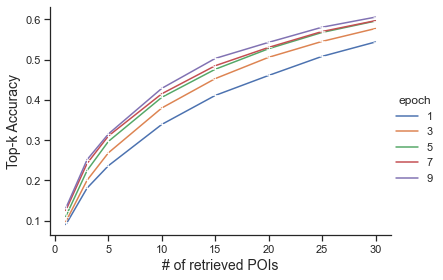

In [143]:
#sn.set_style('ticks')
sn.relplot(data=df, kind='line', x='cuts', y='score',hue='epoch', marker='+', dashes=True, height=4, aspect=1.4,palette="deep")
#plt.xlim(0, 100)
#plt.ylim(0, 0.9)
plt.xlabel("# of retrieved POIs",fontsize=14)
plt.ylabel("Top-k Accuracy",fontsize=14)
plt.savefig('../data/draw_fig/visualize_train.pdf',format='pdf',bbox_inches='tight')

# Human Eval

In [33]:
import json
with open('../data/human_eval/LOG_sp_17_hsp_16_bz_8_lr_2e-05_score_dot_loss_nll_name_True_loc_True_maxloc_5_dist_True_dw_0.5_haversine_False_seed_42_cluster_5_trainfile_train.json_testfile_test.json_distilbert-base-uncased__0_prediction.json') as f:
    data = json.load(f)
    
import random
random.shuffle(data)
r100 = data[:100]

count = 0
for piece in r100:
    piece['human_eval_top3_hit'] = []
    piece['prediction'] = piece['prediction'][:3]
    for p in piece['prediction'][:3]:
        if p in piece['all_answer_entity_list']:
            piece['human_eval_top3_hit'] = [p]
            
# with open('../data/human_eval/random100_eval.json','w') as f:
#     json.dump(r100,f,indent=2)

In [213]:
count = 0
with open('../data/human_eval/random100_eval.json') as f:
    d = json.load(f)
for p in d:
    if p['human_eval_top3_hit'] != []:
        count += 1
print(count)

75


# SelSum

In [1]:
# Read data
import json
with open('../data/TourQue_Knowledge_Cluster.json') as f:
    knowledge = json.load(f)
    
import os
if not os.path.exists('tour_data'):
    os.mkdir('tour_data')

data = list(knowledge.items())
batch_size = int(len(data)/10)

### Export reviews

In [11]:
for i in range(10):
    if not os.path.exists(f'tour_data/sel{i}'):
        os.mkdir(f'tour_data/sel{i}')
        os.mkdir(f'tour_data/sums{i}')
    f1 = open(f'tour_data/sel{i}/test.source','w')
    f2 = open(f'tour_data/sel{i}/test.tags','w')
    for k in range(i*batch_size, (i+1)*batch_size):
        v = data[k][1]
        f1.write(' '.join(v['review']).strip().replace('\n',' </s>')+'\n')
        if len(v['review']) > 9:
            f2.write(' '.join(['1']*10 +  ['0']*(len(v['review'])-10))+'\n')
        else:
            f2.write(' '.join(['1']*(len(v['review'])))+'\n')

    f1.close()
    f2.close()

### Import Sel reviews

In [40]:
for i in range(10):
    f1 = open(f'tour_data/p_sel{i}/test.source')
    for k in range(i*batch_size, (i+1)*batch_size):
        v = data[k][1]
        rev = f1.readline()
        rev = rev.strip().split(' </s> ')
        # assert rev[0]+'\n' in v['review'] # check whether the first rev in the original database
        v['review'] = rev
        v['cluster_map'] = {}
    f1.close()
new_knowledge = dict(data)

In [41]:
with open('../data/TourQue_Knowledge_Sel.json','w') as f:
    json.dump(new_knowledge, f, indent=2)

### Import SelSum reviews

In [3]:
for i in range(10):
    f1 = open(f'tour_data/sums{i}/test.verd')
    f2 = open(f'tour_data/sums{i}/test.pros')
    f3 = open(f'tour_data/sums{i}/test.cons')
    for k in range(i*batch_size, (i+1)*batch_size):
        v = data[k][1]
        verd = f1.readline()
        pros = f2.readline()
        cons = f3.readline()
        v['review'] = [f"Verdict: {verd}",f"Pros: {pros}",f"Cons: {cons}"]
        v['cluster_map'] = {}
    f1.close()
    f2.close()
    f3.close()
new_knowledge = dict(data)

In [4]:
with open('../data/TourQue_Knowledge_SelSum.json','w') as f:
    json.dump(new_knowledge, f, indent=2)

### Combine Sel & SelSum

In [2]:
for i in range(10):
    f1 = open(f'tour_data/sums{i}/test.verd')
    f2 = open(f'tour_data/sums{i}/test.pros')
    f3 = open(f'tour_data/sums{i}/test.cons')
    f4 = open(f'tour_data/p_sel{i}/test.source')
    for k in range(i*batch_size, (i+1)*batch_size):
        v = data[k][1]
        verd = f1.readline()
        pros = f2.readline()
        cons = f3.readline()
        reviews = f4.readline().strip().split(' </s> ')
        v['review'] = [f"Verdict: {verd}",f"Pros: {pros}",f"Cons: {cons}", "Comments:"] + reviews
        v['cluster_map'] = {}
    f1.close()
    f2.close()
    f3.close()
    f4.close()
new_knowledge = dict(data)

In [ ]:
with open('../data/TourQue_Knowledge_SelSum.json','w') as f:
    json.dump(new_knowledge, f, indent=2)

### Average token length Comparison

In [1]:
import json
kf_list = ['../data/TourQue_Knowledge_Cluster.json','../data/TourQue_Knowledge_Sel.json','../data/TourQue_Knowledge_SelSum.json']
for kf in kf_list:
    with open(kf) as f:
        total_len = 0
        data = json.load(f)
        for v in data.values():
            total_len += len((' '.join(v['review'])).split())
        print(total_len/len(data))
        total_len = 0

626.7116573524276
171.22687740132727
68.93704156479218
